In [1]:
import pandas as pd
df1 = pd.read_pickle("movies1.pkl")
df2 = pd.read_pickle("movies2.pkl")
df3 = pd.read_pickle("movies3.pkl")
df = pd.concat([df1,df2, df3]).drop_duplicates().reset_index(drop=True)
len(df)

29940

In [2]:
#Preprocess
df_1 = df[df[df.columns[5:]].sum(axis = 1) != 0]
df_1 = df_1[df_1['Year'] != 2016]
print(len(df_1))

28372


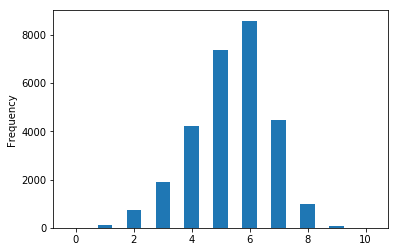

In [3]:
import matplotlib.pyplot as plt
r = df_1['Rating']
r.plot(kind='hist',histtype = 'bar', align = "left",rwidth = 0.5,bins=[0,1, 2,3, 4, 5, 6, 7, 8,9,10,11])
plt.show()

Over 44971, From the dirstribution of the ratings. We found the ratings centered around 6

In [4]:
import numpy as np
r.describe()


count    28372.000000
mean         5.800120
std          1.329555
min          1.100000
25%          5.000000
50%          5.900000
75%          6.700000
max          9.300000
Name: Rating, dtype: float64

In [5]:
df_y1 = df_1[np.logical_and(df_1['Year'] >= 1950, df_1['Year'] < 1960)]
df_y2 = df_1[np.logical_and(df_1['Year'] >= 1960, df_1['Year'] < 1970)]
df_y3 = df_1[np.logical_and(df_1['Year'] >= 1970, df_1['Year'] < 1980)]
df_y4 = df_1[np.logical_and(df_1['Year'] >= 1980, df_1['Year'] < 1990)]
df_y5 = df_1[np.logical_and(df_1['Year'] >= 1990, df_1['Year'] < 2000)]
df_y6 = df_1[df_1['Year'] >= 2000]

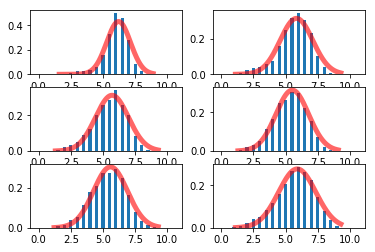

In [6]:
from scipy.stats import norm
df_y = [df_y1, df_y2, df_y3, df_y4, df_y5, df_y6]
i = 0
for col in df_y:
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    i = i + 1
    r = col['Rating']
    ax.hist(r, histtype = 'bar', align = "left",rwidth = 0.5,bins=[0,0.5, 1,1.5, 2,2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8,8.5, 9,9.5, 10,10.5, 11], normed=True)
    
    x = np.linspace(r.min(), r.max(), r.shape[0])

    rv = norm(loc = np.mean(r), scale = np.std(r))
    ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:
weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
Where:
 - R = average rating for across movie genres = (Rating)
 - v = number of votes for across movie genres = (votes)
 - m = a good number of votes to rely on the rating based on votes (m as the average number of votes)
 - C = the mean ratings of all movies (currently 7.0)

In [7]:
def get_values(df, ):
    v = []
    R = []
    for genre in df.columns[5:]:

        v1 = sum(df[df[genre] == 1]['Votes'])
        r1 = np.mean(df[df[genre] == 1]['Rating'])
        R.append(r1)
        v.append(v1)
    m = np.mean(df['Votes'])
    C = np.mean(df['Rating'])
    return np.asarray(R), np.asarray(v), m, C
def true_bayesian_estimate(df):
    R, v, m, C = get_values(df)
    return (v/(v+m))*R + (m/(v+m))*C

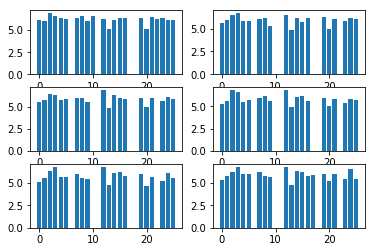

In [8]:
i = 0
for df in df_y:
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    i = i + 1
    y = true_bayesian_estimate(df)
    y = np.nan_to_num(y)
    x = df.columns[5:]
    plt.bar(range(y.shape[0]), y)
plt.show()

From this exploration, we found several generes have rae corresponding values in other variables. We decide to remove those generes for later linear regression

In [114]:
#remove genres
generes = df_1.columns[5:]

remove_genre = []
for genre in generes:
    if((df_1[genre] == 0).all()):
        remove_genre.append(genre)
df_11 = df_1.drop(remove_genre, axis = 1)

# Gross as an indicator of popularity in movie market  
## The average gross over years
To find the trend of the gross over years, apply the sliding average on this time series data to smooth out short-term flucatuations and find the longer-term trend.

In [10]:
def parse_gross(s):    
    try:
        if (s[-1]=="M"):
            return (float(s[1:-1]))
    except:
        return np.nan
df_11["Gross"] = df_11["Gross"].apply(parse_gross)
df_11["Votes"] = pd.to_numeric(df_11["Votes"])


In [11]:
from collections import deque

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k = k
        self.s = deque(maxlen = 2*k + 1)
        self.s.extend([None] * k)
        self.sum = 0.0
        self.num = 0.0
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        self.s.append(x)
        if x is not None:
            self.sum = self.sum + x
            self.num = self.num + 1
        if len(self.s) == 2*(self.k) + 1:
            slidingavg = self.sum/(self.num)
            if (not (self.s[0] is None)):
                self.num = self.num - 1
                self.sum = self.sum - self.s[0]

            return slidingavg
        return None
    

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    if k == 0:
        return s
    sa = SlidingAverage(k)
    s1 = pd.Series()
    snew = [val for val in map(sa.update, s) if val is not None]  
    snew.extend([val for val in map(sa.update, [None]*k) if val is not None])
    s1 = s1.append(pd.Series(snew))
    return s1
subdf = df_11.dropna()
gross_y = subdf.groupby(['Year'])['Gross'].mean()
gross_y_slide_average = compute_sliding_averages(pd.Series(gross_y),5)


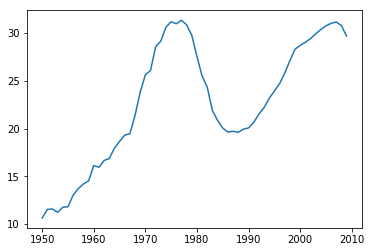

In [12]:
plt.plot(range(1950, 2010), gross_y_slide_average)
plt.show()

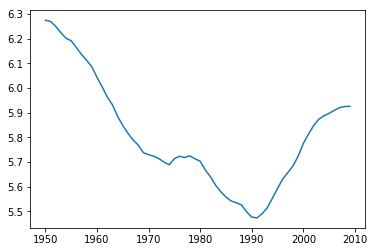

In [13]:
rating_y1 = df_11.groupby(['Year'])['Rating'].mean()
rating_y1_slide_average = compute_sliding_averages(pd.Series(rating_y1),5)
plt.plot(range(1950, 2010), rating_y1_slide_average)
plt.show()

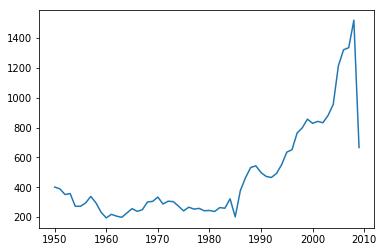

In [14]:
rating_y1 = df_11.groupby(['Year'])['Name'].count()
plt.plot(range(1950, 2010),rating_y1)
plt.show()

R = average rating for across movie genres = (Rating)
v = number of votes for across movie genres = (votes)
m = a good number of votes to rely on the rating based on votes (m as the average number of votes)
C = the mean ratings of all movies (currently 7.0)

In [55]:
from sklearn.linear_model import LinearRegression
def true_bayesian_estimate_1(df):
    R = df["Rating"]
    v = df["Votes"]
    m = v.quantile([.25, .5, .75])[0.25]
    C = (R).mean()
    return (v/(v+m))*R + (m/(v+m))*C
ps = true_bayesian_estimate_1(subdf)
#df_by_year = subdf.groupby(['Year'])

In [56]:
subdf = subdf.assign(Popularity = pd.Series(ps).values )

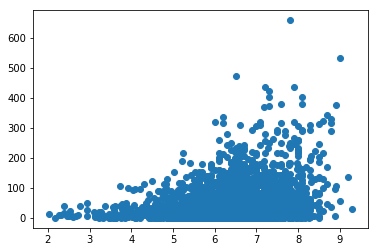

In [72]:
#ax= sns.regplot(x=subdf["Popularity"], y = subdf["Gross"],lowess=True)
plt.scatter(subdf["Popularity"].values.reshape(-1, 1), subdf["Gross"])
plt.show()

In [58]:
from regressors import stats
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=True, normalize=False)  
subdf = subdf[subdf["Gross"]!= 0]
X = np.asarray(subdf["Popularity"]).values.reshape(-1,1)
y = np.asarray(subdf["Gross"])
lm.fit(X, y)
print(lm.coef_)
print(stats.coef_pval(lm, X, y))
stats.summary(lm, X, y)

[ 14.59315081]
[ 0.  0.]
Residuals:
Min      1Q   Median       3Q      Max
-611.5964 -7.5534  14.1299  23.7753  57.5914


Coefficients:
             Estimate  Std. Error  t value  p value
_intercept -66.033729    4.223110 -15.6363      0.0
x1          14.593151    0.183612  79.4780      0.0
---
R-squared:  0.06410,    Adjusted R-squared:  0.06397
F-statistic: 470.08 on 1 features


In [142]:
lm = LinearRegression(fit_intercept=True, normalize=False)  
subdf = subdf[subdf["Gross"]!= 0]
generes = subdf.columns[5:]
remove_genre = []
for genre in generes:
    if((subdf[genre] == 0).all()):
        remove_genre.append(genre)
subdf = subdf.drop(remove_genre, axis = 1)
subdf["Year"] = subdf["Year"] - 1940
X1 = np.asarray(subdf.iloc[:,[2]+list(range(5,subdf.shape[1] - 2))+ [-1]], dtype='float')
#X1 =np.asarray(subdf.iloc[:,list(range(20,23))], dtype='float')


y1 = np.asarray(subdf["Gross"], dtype='float')
lm.fit(X1, y1)

coefs = lm.coef_
pvals = stats.coef_pval(lm, X1, y1)
stats.summary(lm, X1, y1)

Residuals:
Min      1Q  Median       3Q       Max
-616.5301 -9.8367  7.8174  21.0076  101.1671


Coefficients:
              Estimate  Std. Error    t value   p value
_intercept  925.851538   81.169896    11.4063  0.000000
x1            0.551139    0.000285  1931.4762  0.000000
x2           20.403732    1.441316    14.1563  0.000000
x3           22.828447    1.585042    14.4024  0.000000
x4           12.862467    2.943196     4.3702  0.000013
x5           -1.969085    2.498987    -0.7880  0.430751
x6            6.286757    1.157298     5.4323  0.000000
x7            0.077718    1.336389     0.0582  0.953626
x8          -10.410661    1.169986    -8.8981  0.000000
x9           16.911603    2.000861     8.4522  0.000000
x10          18.439661    1.995079     9.2426  0.000000
x11          -6.086841   13.373404    -0.4551  0.649019
x12           4.138580    3.337243     1.2401  0.214974
x13           1.765317    1.922147     0.9184  0.358437
x14           4.466142    2.635785     1.6944  0.

In [143]:
variable_names = [subdf.columns[2]]+ list(subdf.columns[5:subdf.shape[1] - 2]) + ["Popularity"]
list(zip(variable_names, coefs, pvals[1:]))

[('Year', 0.55113873842110628, 0.0),
 ('Genre_Action', 20.403732092467642, 0.0),
 ('Genre_Adventure', 22.828446993073815, 0.0),
 ('Genre_Animation', 12.862466919878838, 1.2593953204076413e-05),
 ('Genre_Biography', -1.9690846160763993, 0.43075129921735922),
 ('Genre_Comedy', 6.2867570665758894, 5.7550968435293726e-08),
 ('Genre_Crime', 0.077718405735572205, 0.95362643765828503),
 ('Genre_Drama', -10.410661493024815, 0.0),
 ('Genre_Family', 16.911603489470998, 0.0),
 ('Genre_Fantasy', 18.439661045189801, 0.0),
 ('Genre_Film-Noir', -6.0868410448598667, 0.64901915860236858),
 ('Genre_History', 4.138580355176483, 0.21497350699127216),
 ('Genre_Horror', 1.7653167435050046, 0.35843724038456037),
 ('Genre_Music', 4.4661417854845453, 0.090229845209400583),
 ('Genre_Musical', 0.81693820707394504, 0.81709200650989233),
 ('Genre_Mystery', 6.3488238922931046, 0.0012171198214661061),
 ('Genre_Romance', 5.2645211416175997, 3.1031382617952019e-05),
 ('Genre_Sci-Fi', 13.995485312611359, 2.345081906440